# Settings to run on Google Colab
Stores the trained models in Google Drive

Comment the following out if running on your own system

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = 'gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/'
#path = 'gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/dataset/Sony'
os.listdir(path)

['dataset',
 'gan_train_Sony_pytorch.ipynb',
 'datasetLoader_pytorch.py',
 'models_pytorch.py',
 'images',
 'models',
 'plots',
 '__pycache__',
 'train_Sony_pytorch.ipynb',
 'gan_models.py']

In [0]:
# Only for Google Colab
import sys
sys.path.insert(0, 'gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark')

# Settings to run on your own system¶
Comment the following out if running on Google Drive

In [0]:
#path = ''

# Folder Structure

In [4]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
# currentDirectory = os.getcwd() # For working on own system
currentDirectory = path # For working on Google Colab

list_files(currentDirectory)

/
    gan_train_Sony_pytorch.ipynb
    datasetLoader_pytorch.py
    models_pytorch.py
    train_Sony_pytorch.ipynb
    gan_models.py
dataset/
    Sony/
        long_temp_down.zip
        short_temp_down.zip
        long_temp_down/
            00002_10_10s.png
            00002_8_10s.png
            00002_9_10s.png
            00002_7_10s.png
            00002_6_10s.png
            00002_5_10s.png
            00002_4_10s.png
            00002_1_10s.png
            00002_2_10s.png
            00001_11_10s.png
            00002_3_10s.png
            00002_0_10s.png
            00001_10_10s.png
            00001_9_10s.png
            00001_8_10s.png
            00001_1_10s.png
            00001_0_10s.png
            00001_4_10s.png
            00001_6_10s.png
            00001_3_10s.png
            00001_7_10s.png
            00001_2_10s.png
            00001_5_10s.png
            00004_6_10s.png
            00004_9_10s.png
            00004_7_10s.png
            00004_8_10s.png
          

# Code

In [0]:
# %load gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py

In [0]:
import os
import torch
import torch.nn as nn
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
# from torchvision.transforms.transforms import ToPILImage as trans
from torch.autograd import Variable
import torch.nn.functional as F
from skimage.measure import compare_ssim

from models_pytorch import *
from datasetLoader_pytorch import SeeingIntTheDarkDataset

trans = transforms.ToPILImage()



In [7]:
n = 1234
np.random.seed(n)
torch.cuda.manual_seed_all(n)
torch.manual_seed(n)



In [0]:
def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, mean=0.0, std=1e-3)
        m.bias.data.fill_(0.0)
        
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data) 
        m.bias.data.fill_(0.0)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



In [9]:
#sitd_dataset = SeeingIntTheDarkDataset(path+'dataset/Sony/short_temp_down/', path+'dataset/Sony/long_temp_down/', transforms.ToTensor())
sitd_dataset = SeeingIntTheDarkDataset(path+'dataset/Sony/short_down/', path+'dataset/Sony/long_down/', transforms.ToTensor())
print('Input Image Size:')
print(sitd_dataset[0][0].size())




Input Image Size:
torch.Size([3, 128, 192])


In [10]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    torch.cuda.set_device(1)

print('Using device: %s'%device)




Using device: cuda


In [0]:
### final params
num_training= 2100
num_validation = 200
num_test = 397

num_epochs = 100
learning_rate = 1e-6
learning_rate_decay = 0.9
reg = 0.001
batch_size = 20

#### dev params
#num_training= 20
#num_validation = 7
#num_test = 7




In [0]:
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(sitd_dataset, mask)

mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(sitd_dataset, mask)

mask = list(range(num_training + num_validation, num_training + num_validation + num_test))
test_dataset = torch.utils.data.Subset(sitd_dataset, mask)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)




In [0]:
def trainAndTestModel(name):

    # Initialize the model for this run
    if name == 'simpleUNET':
        model = simpleUNET()
        # selectedModel = simpleUNET()

    elif name == 'unet':
        model = unet()
        # selectedModel = unet()

    elif name == 'FPN':
        model = FPN(Bottleneck, [2,2,2,2])

    elif name == 'unet_bn':
        model = unet_bn()

    elif name == 'unet_in':
        model = unet_in()
    
    elif name == 'unet_d':
        model = unet_d()

    else:
        print('Name variable passed is incorrect')
        return None

    model.apply(weights_init)

    # Print the model we just instantiated
    print(model)

    model.to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    Loss = []                           #to save all the model losses
    valMSE = []
    valSSIM = []
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (in_images, exp_images) in enumerate(train_loader):
            # Move tensors to the configured device
            in_images = in_images.type(torch.FloatTensor).to(device)
            exp_images = exp_images.type(torch.FloatTensor).to(device)

            # Forward pass
            outputs = model(in_images)

            loss = criterion(outputs, exp_images)
            Loss.append(loss)               #save the loss so we can get accuracies later

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)

        with torch.no_grad():

            overallSSIM = 0
            MSE = 0
            for in_images, exp_images in val_loader:
                in_images = in_images.to(device)
                exp_images = exp_images.to(device)
                outputs = model(in_images)
                MSE += torch.sum((outputs - exp_images) ** 2)
                #outputs = outputs.cpu()
                outputs_np = outputs.permute(0, 2, 3, 1).cpu().numpy() 
                exp_images_np = exp_images.permute(0,2,3,1).cpu().numpy()

                SSIM = 0
                for i in range(len(outputs_np)):
                    SSIM += compare_ssim(exp_images_np[i], outputs_np[i], multichannel=True)

                overallSSIM += SSIM

            
            total = len(val_dataset)
            valSSIM.append(overallSSIM/total)

            current_MSE = MSE/total
            valMSE.append(current_MSE)
            if current_MSE <= np.amin(valMSE):
                torch.save(model.state_dict(),path+'models/ESmodel'+str(epoch+1)+'.ckpt')

            print('Avg Validation MSE on all the {} Val images is: {} '.format(total, current_MSE))
            print('Avg Validation SSIM on all the {} Val images is: {} '.format(total, overallSSIM/total))

    # Training loss and Val MSE curves
    plt.plot(valMSE)
    title='AvgValMSE_vs_Epochs'
    plt.ylabel('Avg Validation MSE')
    plt.xlabel('Epochs')
    plt.title(title)
    plt.savefig(path+'plots/_'+name+title+'.png')
    plt.show()
    plt.close()

    plt.plot(valSSIM)
    title='AvgValSSIM_vs_Epochs'
    plt.ylabel('Avg Validation SSIM')
    plt.xlabel('Epochs')
    plt.title(title)
    plt.savefig(path+'plots/_'+name+title+'.png')
    plt.show()
    plt.close()

    plt.plot(Loss)
    title='Loss_vs_Iterations'
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.title(title)
    plt.savefig(path+'plots/_'+name+title+'.png')
    plt.show()
    plt.close()

    print('Testing ..............................')

    # last_model = model
    best_id = np.argmin(valMSE)
    bestESmodel = model

    bestESmodel.load_state_dict(torch.load(path+'models/ESmodel'+str(best_id+1)+'.ckpt'))
    bestESmodel = bestESmodel.to(device)


    # last_model.eval()
    bestESmodel.eval()
    
        
    with torch.no_grad():

        overallSSIM = 0
        MSE = 0
        count = 0 
        for in_images, exp_images in test_loader:
            
            in_images = in_images.to(device)
            exp_images = exp_images.to(device)
            outputs = bestESmodel(in_images)

            MSE += torch.sum((outputs - exp_images) ** 2)

            # Visualize the output of the best model against ground truth
            in_images_py = in_images.cpu()
            outputs_py = outputs.cpu()
            exp_images_py = exp_images.cpu()
            
            reqd_size = int(in_images.size()[0])

            for i in range(reqd_size):

                img = in_images_py[i].numpy()
                nonZero = np.count_nonzero(img)
                count += 1 
                f, axarr = plt.subplots(1,3)
                title='Input ('+str(round((nonZero*100)/(192*128*3) , 2))+'% Non Zero) vs Model Output vs Ground truth'
                plt.suptitle(title)
                axarr[0].imshow(trans(in_images_py[i]))
                axarr[1].imshow(trans(outputs_py[i]))
                axarr[2].imshow(trans(exp_images_py[i]))
                
                plt.savefig(path+'images/'+name+'_%d.png'%(count))
                plt.close()

                if count % 10 == 0:
                    print('Saving image_%d.png'%(count))

            outputs_np = outputs.permute(0, 2, 3, 1).cpu().numpy()
            exp_images_np = exp_images.permute(0, 2, 3, 1).cpu().numpy()

            SSIM = 0
            for i in range(len(outputs_np)):
                SSIM += compare_ssim(exp_images_np[i], outputs_np[i], multichannel=True)

            overallSSIM += SSIM

        total = len(test_dataset)
        print('Avg Test MSE of the best ES network on all the {} test images: {} '.format(total, MSE/total))
        print('Avg Test SSIM of the best ES network on all the {} test images: {} '.format(total, overallSSIM/total))
        print("Best Epoch with lowest Avg Validation MSE: ", best_id+1)

    torch.save(bestESmodel.state_dict(), path+'models/bestESModel_'+name+'.ckpt')



# Jyothsna Singh

gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py:436: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv1.weight) #Xaviers Initialisation
gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py:446: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv2.weight)
gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py:455: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv3.weight)
gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py:465: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.deconv1.weight)
gdrive/My Drive/Colab Notebooks/Learning-to-See-in-the-Dark/models_pytorch.py:476: UserWarning: nn.ini

simpleUNET(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activ_1): ELU(alpha=1.0)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ_2): ELU(alpha=1.0)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ_3): ELU(alpha=1.0)
  (deconv1): ConvTranspose2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ_4): ELU(alpha=1.0)
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv2): ConvTranspose2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ_5): ELU(alpha=1.0)
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (deconv3): ConvTranspose2d(19, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activ_6): Sigmoid()
)
Epoch 

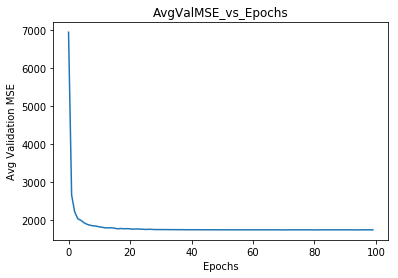

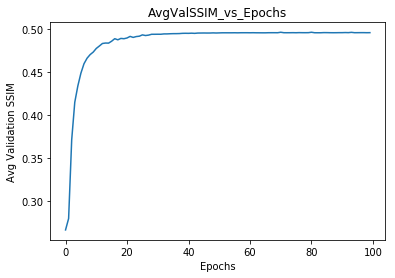

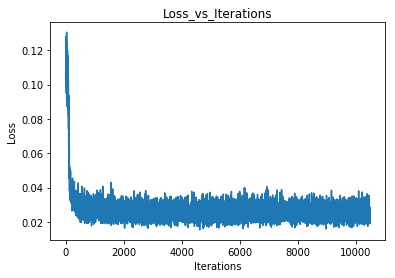

Testing ..............................
Saving image_10.png
Saving image_20.png
Saving image_30.png
Saving image_40.png
Saving image_50.png
Saving image_60.png
Saving image_70.png
Saving image_80.png
Saving image_90.png
Saving image_100.png
Saving image_110.png
Saving image_120.png
Saving image_130.png
Saving image_140.png
Saving image_150.png
Saving image_160.png
Saving image_170.png
Saving image_180.png
Saving image_190.png
Saving image_200.png
Saving image_210.png
Saving image_220.png
Saving image_230.png
Saving image_240.png
Saving image_250.png
Saving image_260.png
Saving image_270.png
Saving image_280.png
Saving image_290.png
Saving image_300.png
Saving image_310.png
Saving image_320.png
Saving image_330.png
Saving image_340.png
Saving image_350.png
Saving image_360.png
Saving image_370.png
Saving image_380.png
Saving image_390.png
Avg Test MSE of the best ES network on all the 397 test images: 1795.4761962890625 
Avg Test SSIM of the best ES network on all the 397 test images: 0.

In [0]:
###############################################################################################################################################
# parameters to select different models ==> Just change here. 

name = 'simpleUNET'

trainAndTestModel(name)

In [0]:
name = 'unet'

trainAndTestModel(name)

unet(
  (inc): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace)
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.01, inplace)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): LeakyReLU(negative_slope=0.01, inplace)
        )
      )
    )
  )
  (down2): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Con

In [0]:
name = 'unet_bn'

trainAndTestModel(name)

unet_bn(
  (inc): double_conv_bn(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace)
    )
  )
  (down1): down_bn(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv_bn(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=

KeyboardInterrupt: ignored

In [0]:
name = 'unet_in'

trainAndTestModel(name)

unet_in(
  (inc): double_conv_in(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01, inplace)
    )
  )
  (down1): down_in(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv_in(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.01, inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(

KeyboardInterrupt: ignored

In [0]:
name = 'unet_d'

trainAndTestModel(name)

unet_d(
  (inc): double_conv_d(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Dropout2d(p=0.3)
      (2): LeakyReLU(negative_slope=0.01, inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Dropout2d(p=0.3)
      (5): LeakyReLU(negative_slope=0.01, inplace)
    )
  )
  (down1): down_d(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv_d(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Dropout2d(p=0.3)
          (2): LeakyReLU(negative_slope=0.01, inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Dropout2d(p=0.3)
          (5): LeakyReLU(negative_slope=0.01, inplace)
        )
      )
    )
  )
  (down2): down_d(
    (mpconv): Sequential(
      (0): MaxPool2d(kerne

KeyboardInterrupt: ignored

# Jyothsna Sastry

In [0]:
name = 'FPN'

trainAndTestModel(name)